## Training

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import os
import bottleneck as bn

In [15]:
### movielens-20m dataset이 있는 곳
DATA_DIR = './dataset/small/'
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')
# OUTPUT_MODEL_DIR = os.path.join(DATA_DIR, 'models/model.pt')

## `load_train_data`

csv 파일을 불러와서, Sparse matrix로 만든다

In [28]:
def load_train_data(csv_file, n_items, n_users, global_indexing=False):
    tp = pd.read_csv(csv_file)
    
    n_users = n_users if global_indexing else tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']

    data = sparse.csr_matrix(
        (np.ones_like(rows), (rows, cols)),
        dtype='float64',
        shape=(n_users, n_items)
    )
    return data

## `load_tr_te_data`

csv 파일을 불러와서 uid의 offset을 맞춰준 뒤 Sparse matrix로 만든다.

In [29]:
def load_tr_te_data(csv_file_tr, csv_file_te, n_items, n_users, global_indexing=False):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    if global_indexing:
        start_idx = 0
        end_idx = len(unique_uid) - 1
    else:
        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix(
        (np.ones_like(rows_tr), (rows_tr, cols_tr)),
        dtype='float64',
        shape=(end_idx - start_idx + 1, n_items)
    )
    data_te = sparse.csr_matrix(
        (np.ones_like(rows_te), (rows_te, cols_te)),
        dtype='float64',
        shape=(end_idx - start_idx + 1, n_items)
    )
    return data_tr, data_te

## `get_data`

전체 데이터를 가져옵니다

In [30]:
def get_data(global_indexing=False):
    UNIQUE_SID_TXT_PATH = os.path.join(OUTPUT_DIR, 'unique_sid.txt')
    UNIQUE_UID_TXT_PATH = os.path.join(OUTPUT_DIR, 'unique_uid.txt')
    TRAIN_CSV_PATH = os.path.join(OUTPUT_DIR, 'train.csv')
    VALIDATION_TR_CSV_PATH = os.path.join(OUTPUT_DIR, 'validation_tr.csv')
    VALIDATION_TE_CSV_PATH = os.path.join(OUTPUT_DIR, 'validation_te.csv')
    TEST_TR_CSV_PATH = os.path.join(OUTPUT_DIR, 'test_tr.csv')
    TEST_TE_CSV_PATH = os.path.join(OUTPUT_DIR, 'test_te.csv')

    unique_sid = list()
    unique_uid = list()

    with open(UNIQUE_SID_TXT_PATH, 'r') as f:
        for line in f:
            unique_sid.append(line.strip())

    with open(UNIQUE_UID_TXT_PATH, 'r') as f:
        for line in f:
            unique_uid.append(line.strip())

    n_items = len(unique_sid)
    n_users = len(unique_uid)

    train_data = load_train_data(
        TRAIN_CSV_PATH,
        n_items,
        n_users,
        global_indexing=global_indexing
    )
    vad_data_tr, vad_data_te = load_tr_te_data(
        VALIDATION_TR_CSV_PATH,
        VALIDATION_TE_CSV_PATH,
        n_items,
        n_users,
        global_indexing=global_indexing
    )
    test_data_tr, test_data_te = load_tr_te_data(
        TEST_TR_CSV_PATH,
        TEST_TE_CSV_PATH,
        n_items,
        n_users, 
        global_indexing=global_indexing
    )

    return train_data, vad_data_tr, vad_data_te, test_data_tr, test_data_te

In [34]:
get_data(global_indexing=False)

(<519x5934 sparse matrix of type '<class 'numpy.float64'>'
 	with 40487 stored elements in Compressed Sparse Row format>,
 <42x5934 sparse matrix of type '<class 'numpy.float64'>'
 	with 2969 stored elements in Compressed Sparse Row format>,
 <42x5934 sparse matrix of type '<class 'numpy.float64'>'
 	with 720 stored elements in Compressed Sparse Row format>,
 <42x5934 sparse matrix of type '<class 'numpy.float64'>'
 	with 3222 stored elements in Compressed Sparse Row format>,
 <42x5934 sparse matrix of type '<class 'numpy.float64'>'
 	with 787 stored elements in Compressed Sparse Row format>)

## `NDCG_binary_at_k_batch`

모르겠음. 뭔가 정확도 검증하는 함수일거같은데...

In [93]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

## `Recall_at_k_batch`

모르겠음. 뭔가 정확도 검증하는 함수일거같은데...

In [94]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

# 여기서부터 학습 시작

In [33]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from tqdm import tqdm_notebook as tqdm
import pickle
import random
from IPython.display import clear_output

seed = 92819
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")

In [58]:
data = (m.astype('float32') for m in get_data(global_indexing=False))

train_data, valid_1_data, valid_2_data, test_1_data, test_2_data = data
n_users, n_items = train_data.shape

In [59]:
import json
import re
import ipykernel
import requests
from requests.compat import urljoin
from notebook.notebookapp import list_running_servers

def get_notebook_name():
    kernel_id = re.search('kernel-(.*).json', ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'), params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['path']
                return relative_path.split('/')[-1].split('.')[0]

In [60]:
ser_model_fn = 'model_' + get_notebook_name().replace(' ', '_') + '.pt'

## Swish Activation Function

https://data-newbie.tistory.com/262

In [62]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def swish_(x):
    return x.mul_(torch.sigmoid(x))

## KL Divergence

- entrophy: https://hyunw.kim/blog/2017/10/14/Entropy.html
- cross-entrophy: https://hyunw.kim/blog/2017/10/26/Cross_Entropy.html
- KL-divergence: https://hyunw.kim/blog/2017/10/27/KL_divergence.html

In [74]:
def kl(q_distr, p_distr, weights, eps=1e-7):
    mu_q, logvar_q = q_distr
    mu_p, logvar_p = p_distr
    return 0.5 * (((logvar_q.exp() + (mu_q - mu_p).pow(2)) / (logvar_p.exp() + eps) + logvar_p - logvar_q - 1).sum(dim=-1) * weights).mean()

def simple_kl(mu_q, logvar_q, logvar_p_scale, norm):
    return (-0.5 * ((1 + logvar_q - mu_q.pow(2)/logvar_p_scale - logvar_q.exp()/logvar_p_scale)).sum(dim=-1) * norm).mean()

## `log_norm_pdf`

log-normal probability density function

In [75]:
def log_norm_pdf(x, mu, logvar):
    return -0.5 * (logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())

def log_norm_std_pdf(x):
    return -0.5 * (np.log(2 * np.pi) + x.pow(2))

## `DeterministicDecoder`

In [69]:
class DeterministicDecoder(nn.Linear):
    def __init__(self, *args):
        super(DeterministicDecoder, self).__init__(*args)

    def forward(self, *args):
        output = super(DeterministicDecoder, self).forward(*args)
        return output, 0

## `StochasticDecoder`

In [76]:
class StochasticDecoder(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(StochasticDecoder, self).__init__(in_features, out_features, bias)

        self.in_features = in_features
        self.out_features = out_features
        self.logvar = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logvar.data.fill_(-2)

    def forward(self, input):
        if self.training:
            std = torch.exp(self.logvar)
            a = F.linear(input, self.weight, self.bias)
            eps = torch.randn_like(a)
            b = eps.mul_(torch.sqrt_(F.linear(input * input, std)))
            output = a + b

            kl = simple_kl(self.weight, self.logvar, 1, 1)
            # kl = (-0.5 * (1 + self.logvar - self.weight.pow(2) - self.logvar.exp())).sum(dim=-1).mean()
            return output, kl

        else:
            output = F.linear(input, self.weight, self.bias)
            return output, 0

## `GaussianMixturePrior`

In [71]:
class GaussianMixturePrior(nn.Module):
    def __init__(self, latent_dim, gaussians_number):
        super(GaussianMixturePrior, self).__init__()
        
        self.gaussians_number = gaussians_number
        
        self.mu_prior = nn.Parameter(torch.Tensor(latent_dim, gaussians_number))
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(latent_dim, gaussians_number))
        self.logvar_prior.data.fill_(0)
        
    def forward(self, z):
        density_per_gaussian = log_norm_pdf(
            x=z[:, :, None],
            mu=self.mu_prior[None, ...].detach(),
            logvar=self.logvar_prior[None, ...].detach()
        ).add(-np.log(self.gaussians_number))
        
        return torch.logsumexp(density_per_gaussian, dim=-1)

## `GaussianMixturePriorWithAprPost`

In [72]:
class GaussianMixturePriorWithAprPost(nn.Module):
    def __init__(self, latent_dim, input_count):
        super(GaussianMixturePriorWithAprPost, self).__init__()
        
        self.gaussians_number = 1

        self.mu_prior = nn.Parameter(torch.Tensor(latent_dim, self.gaussians_number))
        self.mu_prior.data.fill_(0)

        self.logvar_prior = nn.Parameter(torch.Tensor(latent_dim, self.gaussians_number))
        self.logvar_prior.data.fill_(0)

        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(
            latent_dim,
            self.gaussians_number
        ))
        self.logvar_uniform_prior.data.fill_(10)

        self.user_mu = nn.Embedding(input_count, latent_dim)
        self.user_logvar = nn.Embedding(input_count, latent_dim)

    def forward(self, z, idx):
        density_per_gaussian1 = log_norm_pdf(
            x=z[:, :, None],
            mu=self.mu_prior[None, :, :].detach(),
            logvar=self.logvar_prior[None, :, :].detach()
        ).add(np.log(1/5 - 1/20))

        density_per_gaussian2 = log_norm_pdf(
            x=z[:, :, None],
            mu=self.user_mu(idx)[:, :, None].detach(),
            logvar=self.user_logvar(idx)[:, :, None].detach()
        ).add(np.log(4/5 - 1/20))

        density_per_gaussian3 = log_norm_pdf(
            x=z[:, :, None],
            mu=self.mu_prior[None, :, :].detach(),
            logvar=self.logvar_uniform_prior[None, :, :].detach()
        ).add(np.log(1/10))

        density_per_gaussian = torch.cat([
            density_per_gaussian1,
            density_per_gaussian2,
            density_per_gaussian3
        ], dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)

In [80]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, matrix_dim, axis):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(matrix_dim[1], hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        self.prior = GaussianMixturePriorWithAprPost(latent_dim, matrix_dim[0])
        self.decoder = DeterministicDecoder(latent_dim, matrix_dim[1])        
        self.axis = axis


    def encode(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
    
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))

        return self.fc21(h5), self.fc22(h5)


    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu


    def decode(self, z):
        return self.decoder(z)


    def forward(
        self,
        user_ratings,
        user_idx,
        beta=1,
        dropout_rate=0.5,
        calculate_loss=True,
        mode=None
    ):
        if mode == 'pr':
            mu, logvar = self.encode(user_ratings, dropout_rate=dropout_rate)
        elif mode == 'mf':
            mu, logvar = self.encode(user_ratings, dropout_rate=0)
            
        z = self.reparameterize(mu, logvar)

        x_pred, decoder_loss = self.decode(z)
        
        NLL = -(F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
        
        if calculate_loss:
            if mode == 'pr':
                norm = user_ratings.sum(dim=-1)
                KLD = -(self.prior(z, user_idx) - log_norm_pdf(z, mu, logvar)).sum(dim=-1).mul(norm).mean()
                loss = NLL + beta * KLD + decoder_loss

            elif mode == 'mf':
                KLD = NLL * 0
                loss = NLL + decoder_loss
            
            return (NLL, KLD), loss
            
        else:
            return x_pred

    def set_embeddings(self, train_data, momentum=0, weight=None):
        istraining = self.training
        self.eval()

        for batch in generate(
            batch_size=500,
            device=device,
            data_1=train_data,
            axis=self.axis
        ):
            user_ratings = batch.get_ratings_to_dev()
            users_idx = batch.get_idx()

            new_user_mu, new_user_logvar = self.encode(user_ratings, 0)

            old_user_mu = self.prior.user_mu.weight.data[users_idx,:].detach()
            old_user_logvar = self.prior.user_logvar.weight.data[users_idx,:].detach()

            if weight:
                old_user_var = torch.exp(old_user_logvar)
                new_user_var = torch.exp(new_user_logvar)

                post_user_var = 1 / (1 / old_user_var + weight / new_user_var)
                post_user_mu = (old_user_mu / old_user_var + weight * new_user_mu / new_user_var) * post_user_var

                self.prior.user_mu.weight.data[users_idx,:] = post_user_mu
                self.prior.user_logvar.weight.data[users_idx,:] = torch.log(post_user_var + new_user_var)
            else:
                self.prior.user_mu.weight.data[users_idx,:] = momentum * old_user_mu + (1-momentum) * new_user_mu
                self.prior.user_logvar.weight.data[users_idx,:] = momentum * old_user_logvar + (1-momentum) * new_user_logvar

        if istraining:
            self.train()
        else:
            self.eval()

## `generate`

`Batch` 함수를 generator로 이용할 수 있도록 wrapping.

In [81]:
def generate(
    batch_size,
    device,
    axis,
    data_1,
    data_2=None,
    shuffle=False,
    samples_perc_per_epoch=1
):
    assert axis in ['users', 'items']
    assert 0 < samples_perc_per_epoch <= 1
    
    if axis == 'items':
        data_1 = data_1.T
        if data_2 is not None:
            data_2 = data_2.T
    
    total_samples = data_1.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in tqdm(range(0, samples_per_epoch, batch_size)):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_1, data_2)

## `Batch`

데이터를 쪼개서 각각의 환경으로 나눔.

In [82]:
class Batch:
    def __init__(self, device, idx, data_1, data_2=None):
        self._device = device
        self._idx = idx
        self._data_1 = data_1
        self._data_2 = data_2
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)

    def get_ratings(self, is_test=False):
        data = self._data_2 if is_test else self._data_1
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_test=False):
        return torch.Tensor(self.get_ratings(is_test).toarray()).to(self._device)

## `validate`

NDCG? 로 검증하는 코드인듯

In [83]:
def validate(model, data_1, data_2, axis, mode, samples_perc_per_epoch=1):
    model.eval()
    batch_size = 500
    ndcg_dist = []
    
    
    for batch in generate(
        batch_size=batch_size,
        device=device,
        axis=axis,
        data_1=data_1,
        data_2=data_2,
        samples_perc_per_epoch=samples_perc_per_epoch
    ):
        
        ratings = batch.get_ratings_to_dev()
        idx = batch.get_idx_to_dev()
        ratings_test = batch.get_ratings(is_test=True)
    
        pred_val = model(ratings, idx, calculate_loss=False, mode=mode).cpu().detach().numpy()
        
        if not (data_1 is data_2):
            pred_val[batch.get_ratings().nonzero()] = -np.inf
        ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, ratings_test))

    ndcg_dist = np.concatenate(ndcg_dist)

    return ndcg_dist[~np.isnan(ndcg_dist)].mean()

In [84]:
def run(model, opts, train_data, batch_size, n_epochs, axis, beta, mode):
    global best_ndcg
    global ndcgs_tr_pr, ndcgs_tr_mf, ndcgs_va_pr, ndcgs_va_mf
    
    for epoch in range(n_epochs):
        model.train()
        NLL_loss = 0
        KLD_loss = 0

        for batch in generate(
            batch_size=batch_size,
            device=device,
            axis=axis,
            data_1=train_data,
            shuffle=True
        ):
            ratings = batch.get_ratings_to_dev()
            idx = batch.get_idx_to_dev()

            for optimizer in opts:
                optimizer.zero_grad()
                
            (NLL, KLD), loss = model(ratings, idx, beta=beta, mode=mode)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()
            
            NLL_loss += NLL.item()
            KLD_loss += KLD.item()
            

        print('NLL_loss', NLL_loss, 'KLD_loss', KLD_loss)

In [90]:
def get_opts(model, lr=5e-4):
    decoder_params = set(model.decoder.parameters())
    embedding_params = set(model.prior.user_mu.parameters()) | set(model.prior.user_logvar.parameters())
    encoder_params = set(model.parameters()) - decoder_params - embedding_params

    optimizer_encoder = optim.Adam(encoder_params, lr=lr)
    optimizer_decoder = optim.Adam(decoder_params, lr=lr)
    optimizer_embedding = optim.Adam(embedding_params, lr=lr)

    print('encoder\n', [x.shape for x in encoder_params])
    print('embedding\n', [x.shape for x in embedding_params])
    print('decoder\n', [x.shape for x in decoder_params])
    
    return optimizer_encoder, optimizer_decoder, optimizer_embedding

In [96]:
best_ndcg = -np.inf
ndcgs_tr_pr, ndcgs_tr_mf, ndcgs_va_pr, ndcgs_va_mf = [], [], [], []
var_param_distance = []

hidden_dim = 600
latent_dim = 200

model_i = VAE(hidden_dim, latent_dim, (n_users, n_items), 'users').to(device)
model_i.set_embeddings(train_data)

print(model_i)

optimizer_encoder_i, optimizer_decoder_i, _ = get_opts(model_i)


VAE(
  (fc1): Linear(in_features=5934, out_features=600, bias=True)
  (ln1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=600, out_features=600, bias=True)
  (ln2): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=600, out_features=600, bias=True)
  (ln3): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=600, out_features=600, bias=True)
  (ln4): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
  (fc5): Linear(in_features=600, out_features=600, bias=True)
  (ln5): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
  (fc21): Linear(in_features=600, out_features=200, bias=True)
  (fc22): Linear(in_features=600, out_features=200, bias=True)
  (prior): GaussianMixturePriorWithAprPost(
    (user_mu): Embedding(519, 200)
    (user_logvar): Embedding(519, 200)
  )
  (decoder): DeterministicDecoder(in_features=200, out_features=5934, bias=True)
)
encoder
 [torch.Size([200, 1]), torch

ndcg 0.15793422046162656 : : : 0.14130113835754232


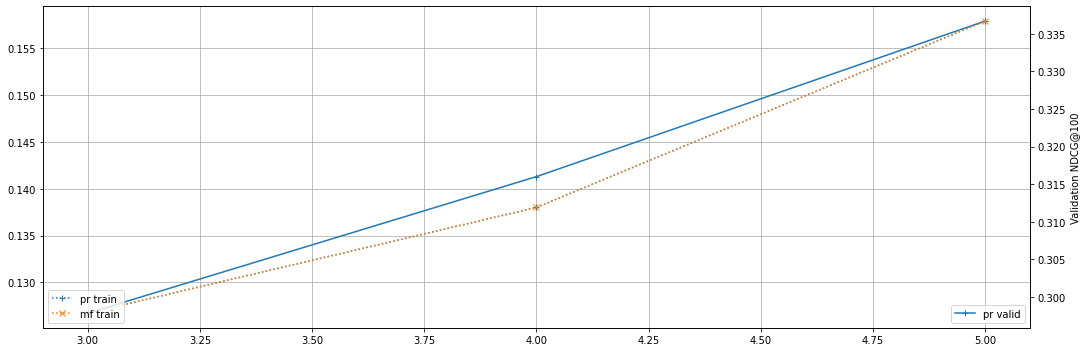


NLL_loss 1258.3818359375 KLD_loss 5249.326416015625


KeyboardInterrupt: 

In [97]:
for epoch in range(50):
    run(model_i, [optimizer_encoder_i],
        train_data, batch_size=500, n_epochs=3, axis='users', mode='pr', beta=0.005)
    model_i.set_embeddings(train_data)
    run(model_i, [optimizer_decoder_i],
        train_data, batch_size=500, n_epochs=1, axis='users', mode='mf', beta=None)
    
    model = model_i
    axis = 'users'
    ndcg_ = validate(model, train_data, train_data, axis, 'mf', 0.01)
    ndcgs_tr_mf.append(ndcg_)
    ndcg_ = validate(model, train_data, train_data, axis, 'pr', 0.01)
    ndcgs_tr_pr.append(ndcg_)
    ndcg_ = validate(model, valid_1_data, valid_2_data, axis, 'pr', 1)
    ndcgs_va_pr.append(ndcg_)

    
    clear_output(True)
    
    i_min = np.array(ndcgs_va_pr).argsort()[-len(ndcgs_va_pr)//2:].min()

    print('ndcg', ndcgs_va_pr[-1], ': : :', best_ndcg)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(15,5)

    ax1.plot(range(i_min, len(ndcgs_va_pr)), ndcgs_va_pr[i_min:], '+-', label='pr valid')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(range(i_min, len(ndcgs_va_pr)), ndcgs_tr_pr[i_min:], '+:', label='pr train')
    ax2.plot(range(i_min, len(ndcgs_va_pr)), ndcgs_tr_mf[i_min:], 'x:', label='mf train')
    ax2.legend(loc='lower left')

    fig.tight_layout()
    plt.ylabel("Validation NDCG@100")
    plt.xlabel("Epochs")
    plt.show()

    if ndcg_ > best_ndcg:
        best_ndcg = ndcg_
        torch.save(model.state_dict(), ser_model_fn)
        
    if ndcg_ < best_ndcg / 2 and epoch > 10:
        break